<div>
    <img src="https://hakaimagazine.com/wp-content/uploads/header-titanic-solar-storms.jpg"/>
</div>

# Kaggle Workflow - A Titanic Undertaking

In this project we will be participating in the [legendary Titanic competition](https://www.kaggle.com/c/titanic) on Kaggle. This is an excellent project to take part in to both become familiar with machine learning, as well as how to use the Kaggle platform. There are two main goals in this project:

* Build a machine learning model that can predict whether or not a passenger on board the [Titanic](https://en.wikipedia.org/wiki/Titanic) survived
* Create a modular, adaptive workflow that can be applied to any [Kaggle competition](https://www.kaggle.com/competitions) or Machine Learning project

## Import Libraries

This project will be using many models and tools from the [scikit-learn](https://scikit-learn.org/stable/) and [scipy](https://scipy.org/) libraries.

In [1]:
#models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron

#tools
from scipy.stats import randint
from scipy.stats import loguniform
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
import time

#we include the following to silence the warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

print(train.shape)
print(holdout.shape)

(891, 12)
(418, 11)


### Data Processing Functions

In [2]:
def process_missing(df):
    #handles missing values from the dataset
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    #categorizes age into bins
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    #categorizes fare price into bins
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    #categorizes cabin type into bins
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    #extracts and categorizes ti
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def process_fam(df):
    df['Fam_onboard'] = df['SibSp'] + df['Parch']
    df['Fam_onboard'] = df['Fam_onboard'].fillna(0.0)
    return df

def process_alone(df):
    df['Is_alone'] = (df['Fam_onboard'] == 0).astype(int)
    df.drop('Fam_onboard', axis=1, inplace=True)
    return df

def process_scaling(df):
    #list of columns to scale
    cols = ['SibSp', 'Parch', 'Fare', 'Age']

    #rescales data in specified columns
    for col in cols:
        df[col + '_scaled'] = minmax_scale(df[col])
        # df.drop(col, axis=1, inplace=True)
    return df

def create_dummies(df,column_name):
    #implements one-hot encoding for given column
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def process_all(df):
    name = [x for x in globals() if globals()[x] is df][0]
    
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    for col in ['Age_categories', 'Fare_categories', 'Title',
                'Cabin_type', 'Sex', 'Pclass', 'Embarked']:
        df = create_dummies(df, col)
        
    print(f'Processing {name} complete!')
    return df

#process train and holdout sets
train = process_all(train)
holdout = process_all(holdout)

#print shapes (holdout should have at least 1 fewer columns)
print(f'train: {train.shape}')
print(f'holdout: {holdout.shape}')

Processing train complete!
Processing holdout complete!
train: (891, 49)
holdout: (418, 47)


### Creating Some Helper Functions

The following are helper functions to save us from reusing code multiple times. These are functions that don't change the data, rather they help present and visualize it.

In [3]:
title_map = {
        #column : [title, xlabel, bins]
        'Pclass': ['Passenger Class', 'Class', 3],
        'Sex': ['Sex', 'Sex', 4],
        'Age': ['Age', 'Age', 5],
        'SibSp': ['Sibling & Spouse Count', '# of Siblings/Spouses', 8],
        'Parch': ['Parent & Child Count', '# of Parents/Children', 6],
        'Fare': ['Fare Paid', 'Fare', 10],
        'Cabin': ['Cabin Number', 'Cabin Type', 10],
        'Embarked': ['Embarkment Point', 'Embarkment Point', 3],
        'Fam_onboard': ['Family Member Count', '# of Family Members', 10]
    }

def plot_distr(column):
    #get title & label
    title = title_map[column][0]
    xlabel = title_map[column][1]
    bin_count = title_map[column][2]
    
    #figure details
    fig, ax = plt.subplots(figsize = (12,8))
    fig.suptitle(f'{title} Distribution', fontsize=22, y=0.92)
    
    sns.histplot(data=train, x=column, hue='Survived', bins=bin_count,
                 palette='deep', alpha=1, multiple="dodge")

    #plot details    
    ax.set_xlabel(f'{xlabel}', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    labels = ['Survived', 'Died']
    ax.legend(labels, frameon=True, bbox_to_anchor=(1, 1), fontsize=14)
    plt.show()

def plot_vs_survival(column):
    #get title & label
    title = title_map[column][0]
    xlabel = title_map[column][1]
    
    #figure details
    fig, ax = plt.subplots(figsize = (12,8))
    fig.suptitle(f'Survival Rate vs. {title}', fontsize=22, y=0.92)
    
    sns.barplot(x=train[column], y=train['Survived'], palette='deep')
    ax.bar_label(ax.containers[0], fmt='%.2f', fontsize=14)

    #plot details
    if column == 'SibSp':
        ax.set_xlim(-0.5,4.5,1)
    ax.set_xlabel(f'{xlabel}', fontsize=16)
    ax.set_ylabel('Survival Rate', fontsize=16)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    plt.show()
    
def plot_correlation_heatmap(df):
    cols_to_drop = ['Survived', 'PassengerId']
    df_cols = df.columns
    df_cols = df_cols.drop(cols_to_drop)
    
    #create correlation matrix
    corr = df[df_cols].corr()
    
    #create mask to hide "upper" half
    # sns.set(style="white")
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    #figure details
    fig, ax = plt.subplots(figsize=(11, 9))
    ax.set_title('Feature Correlation Heatmap', fontsize=22)

    #plot details
    cmap = sns.diverging_palette(220, 5, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True,
                linewidths=.5, linecolor='black', cbar_kws={'shrink': .8})
    
    #colorbar details
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([-1, -0.5, 0, .5, 1])
    cbar.ax.tick_params(axis='both', which='both', length=0)
        
    plt.show()
    
def score_comp(results, col='Scores'):
    scores = []
    names = []
    
    for i in range(len(results)):
        scores.append(results[i]['best_score'])
        names.append(results[i]['name'])
     
    comp = pd.DataFrame()
    comp['Model'] = names
    comp[col] = scores
    comp.set_index('Model', inplace=True)
    return comp

def plot_scores_vs_kaggle(scores, kaggle):
    #predicted scores from models
    accuracies = []
    names = ['Logistic\nRegression', 'K-Nearest\nNeighbor', 'Random\nForest',
             'Support Vector\nMachine', 'Stochastic\nGradient Descent', 'Linear\nPerceptron']
    
    # #have to input these manually
    # kaggle = [0.78229, 0.75598, 0.75358, 0.76794, 0.77033, 0.75598]
    
    #extracts actual score
    for i in range(len(scores)):
        accuracies.append(scores[i]['best_score'])
    
    #figure details
    fig, ax = plt.subplots(figsize = (12,8))
    fig.suptitle(f'Kaggle Score vs. Predicted Score', fontsize=22, y=0.92)
    
    #plot predicted
    sns.barplot(x=names, y=accuracies, palette='deep', alpha=0.3, label='Predicted')
    ax.bar_label(ax.containers[0], fmt='%.4f', fontsize=14)
    
    #plot kaggle
    sns.barplot(x=names, y=kaggle, palette='deep', alpha=0.7, label='Kaggle')
    ax.bar_label(ax.containers[1], fmt='%.4f', fontsize=14)

    #plot horizontal lines
    ax.axhline(y=0.75, color='red', linestyle='dashed', alpha=0.7, label='Minimum')
    ax.axhline(y=0.8, color='grey', linestyle='dashed', alpha=0.7, label='Goal')
    
    #plot details
    ax.set_ylim(0.68, 0.85)
    ax.set_xlabel('Models', fontsize=16)
    ax.set_ylabel('Accuracy', fontsize=16)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(frameon=True, bbox_to_anchor=(1, 1), fontsize=12)
    plt.show()
    
def plot_model_progression(df):
    dfT = df.T
    #figure details
    fig, ax = plt.subplots(figsize = (12,8))
    fig.suptitle(f'Model Progression of Predicted Accuracy', fontsize=22, y=0.92)
    
    #plot
    for i in df.index:
        sns.lineplot(data=dfT[i], marker='o')
    
    #plot details
    labels = ['Logistic Regression', 'K-Nearest Neighborrs', 'Random Forest',
              'Support Vector Machine', 'Stochastic Gradient Descent',
              'Linear Perceptron']
    ax.set_ylim(0.70, 0.85)
    ax.set_xlabel('Iterations', fontsize=16)
    ax.set_ylabel('Predicted Accuracy', fontsize=16)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(labels, frameon=True, fontsize=12)
    plt.show()

# Data Exploration

In [4]:
print(train.dtypes,'\n')
print(f'train: {train.shape}')
print(f'holdout: {holdout.shape}')

PassengerId                      int64
Survived                         int64
Pclass                           int64
Name                            object
Sex                             object
Age                            float64
SibSp                            int64
Parch                            int64
Ticket                          object
Fare                           float64
Embarked                        object
Age_categories                category
Fare_categories               category
Title                           object
Cabin_type                      object
Age_categories_Missing           uint8
Age_categories_Infant            uint8
Age_categories_Child             uint8
Age_categories_Teenager          uint8
Age_categories_Young Adult       uint8
Age_categories_Adult             uint8
Age_categories_Senior            uint8
Fare_categories_0-12             uint8
Fare_categories_12-50            uint8
Fare_categories_50-100           uint8
Fare_categories_100+     

## SibSp - Siblings & Spouses

According to the [data dictionary](https://www.kaggle.com/c/titanic/data), the `SibSp` column represents the number of siblings / spouses that that passenger had aboard the Titanic. Let's explore this data a little further by looking at the distribution of siblings/spouses and their survival rate.

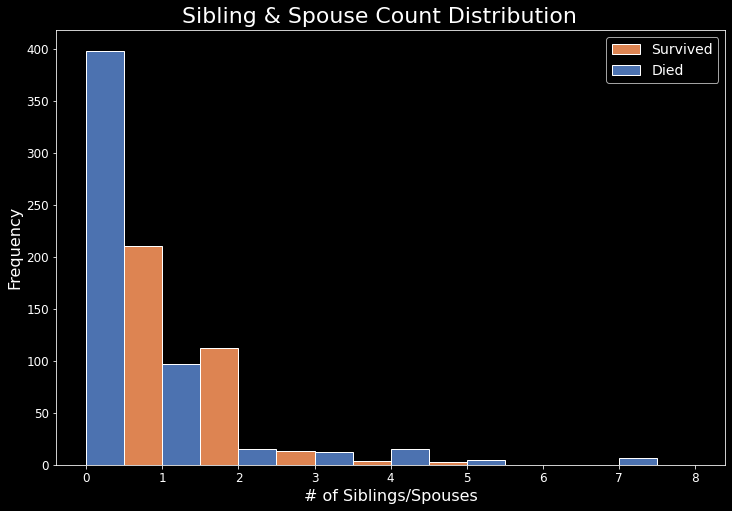

In [5]:
plot_distr('SibSp')

In the above chart we can see that the majority of passengers aboard the Titanic were single and/or had no siblings on board with them. It appears that roughly **2/3** of passengers who were single and/or had no siblings did not survive. If you were married and/or had at least one sibling on board, that ratio approaches roughly **1/2**.

In [6]:
sibsp_pivot = train.pivot_table(index='SibSp',values='Survived')
sibsp_pivot

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


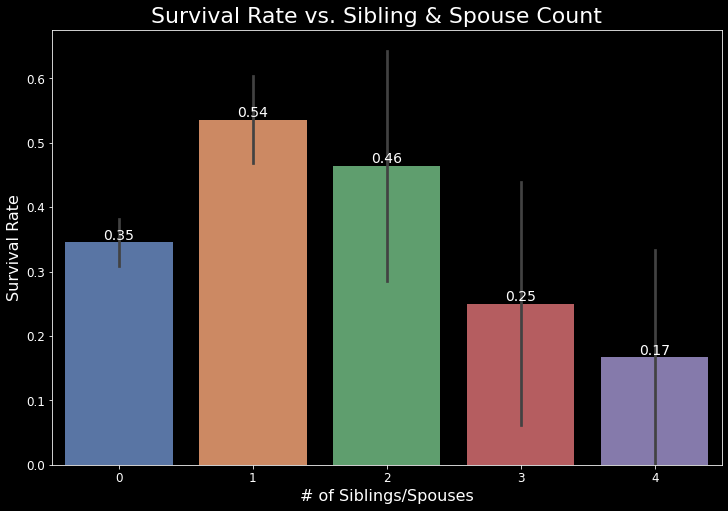

In [7]:
plot_vs_survival('SibSp')

The chart above shows us the survival rate of passenger who had X# of siblings/spouses on board the Titanic. It appears that if you were married or had one sibling on board with you, your odds of survival peaked at roughly **54%**. If you had 4 siblings/spouses, then your odds of survival dropped to **17%**. Unfortunately, the survival rate for any passenger that had 5 or more siblings/spouses was **0%**, and thus is not shown on the graph.

## Parch - Parents & Children

According to the [data dictionary](https://www.kaggle.com/c/titanic/data), the `Parch` column represents the number of parents or children the passenger had aboard the Titanic. Let's also explore this data further by looking at the distribution of parents/children, as well as their survival rates.

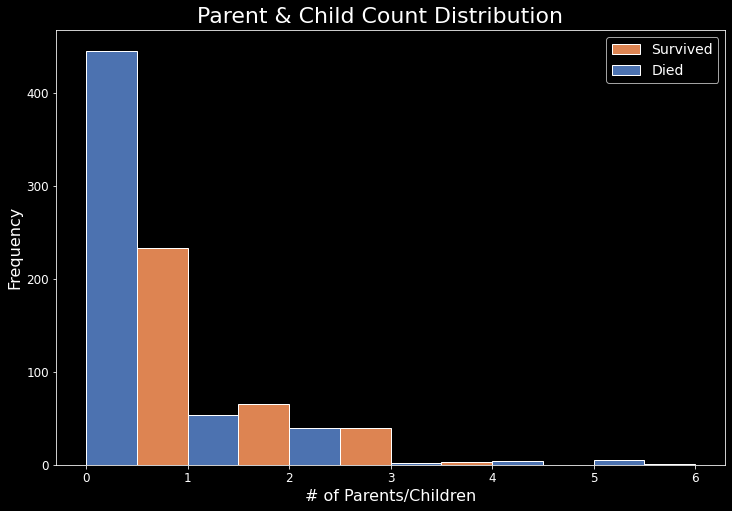

In [8]:
plot_distr('Parch')

The above plot shows very similar distributions as the `SibSp` plot. Roughly **2/3** of passengers with no parent/child on board didn't survive. With 1 or more, that ratio approaches **1/2**.

In [9]:
parch_pivot = train.pivot_table(index="Parch",values="Survived")
parch_pivot

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


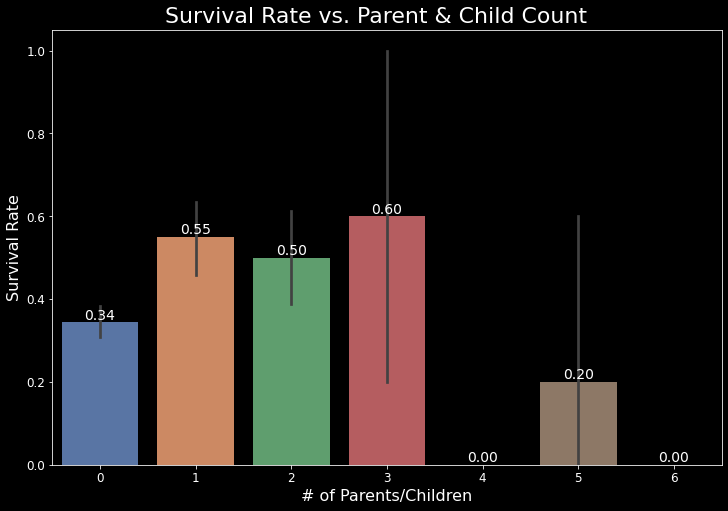

In [10]:
plot_vs_survival('Parch')

Here we can see the survival rate for passengers with certain numbers of parents or children on board. It does make sense that if you have 3 parents/children on board, your survival rate is higher than if you had 0. This is most likely because women and children had priority access to the lifeboats.

## Combining SibSp and Parch

The two columns `SibSp` and `Parch` both represent numbers of family members on board the Titanic. Since they are both numerical datatypes, and they both represent similar things, we can go ahead and combine then and see if/how it affects the distribution and survival rates.

In [11]:
#creating new column by combining two existing ones
train = process_fam(train)
holdout = process_fam(holdout)

In [12]:
train['Fam_onboard'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Fam_onboard, dtype: int64

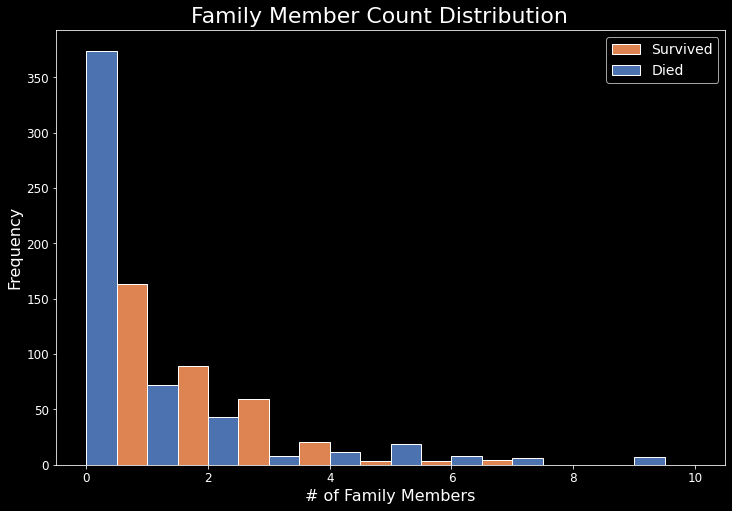

In [13]:
plot_distr('Fam_onboard')

In the combined `Fam_onboard` column, it's much easier to see how many family members each passenger has on board with them. The overwhelming majority of passengers were actually single passengers. They were also the group that had the most deaths. Since they didn't have children with them, they weren't given lifeboat priority.

In [14]:
fam_pivot = train.pivot_table(index='Fam_onboard', values="Survived")
fam_pivot

,Survived
Fam_onboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


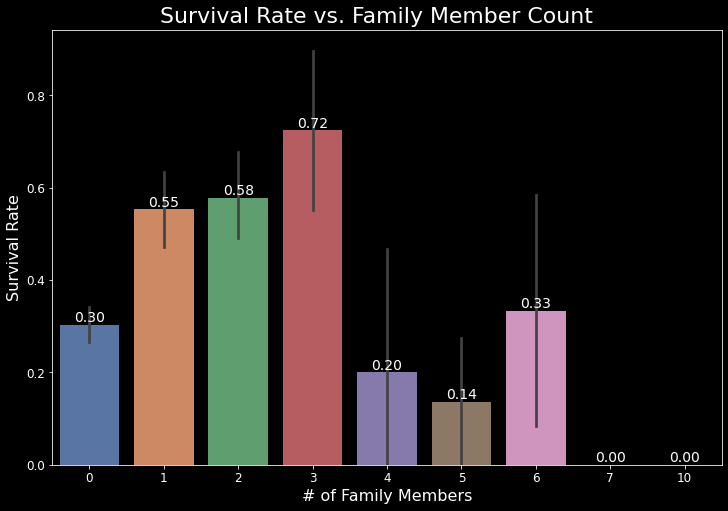

In [15]:
plot_vs_survival('Fam_onboard')

If we look at the above plot, we can clearly see that if you were on board the Titanic with at least 1 family member, your odds of survival greatly increase. Having just one family member onboard increases your survival rate by **25%**. Relative to the original `SibSp` and `Parch` columns, the odds of a passenger's survival goes up if they have any family members on board - the only exception being if you have 5 family members, in which case it goes down by about **7%**. In both the `SibSp` and `Parch` columns, if you had 0 family on board your odds of survival were **~34%**. However, in the combined `Fam_onboard` column, your odds are now at **30%**. This can be seen in the table below.

## Survival Rate Comparisons vs. Number of Family Members On Board

In [16]:
#frames to concat
frames = [sibsp_pivot, parch_pivot, fam_pivot]

#rename columns in pivot tables
sibsp_pivot.rename(columns={'Survived': 'SibSp'}, inplace=True)
parch_pivot.rename(columns={'Survived': 'Parch'}, inplace=True)
fam_pivot.rename(columns={'Survived': 'Fam_onboard'}, inplace=True)

#concat dataframes
survival_comp = pd.concat(frames, axis=1)
survival_comp.index.name = '#'
survival_comp.fillna(0.0, inplace=True)
survival_comp

,SibSp,Parch,Fam_onboard
#,,,
0,0.345395,0.343658,0.303538
1,0.535885,0.550847,0.552795
2,0.464286,0.500000,0.578431
3,0.250000,0.600000,0.724138
4,0.166667,0.000000,0.200000
5,0.000000,0.200000,0.136364
8,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.333333
7,0.000000,0.000000,0.000000


# New Feature - Was The Passenger Alone?

Because of the table above, we can create a new feature - one that simplifies a lot of the information we've been working with. Was the passenger alone? This new feature will be a binary column containing the value:

* `1` - if the passenger has zero family members onboard
* `0` - if the passenger has one or more family members onboard

Let's create a function that will process our data and create this new feature.

In [17]:
train = process_alone(train)
holdout = process_alone(holdout)

train['Is_alone'].value_counts()

1    537
0    354
Name: Is_alone, dtype: int64

# Selecting Best Features

We can use scikit-learn's builtin [feature_selection.RFECV class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html) to automate selecting the b est-performing features using recursive feature elimination. To make things easier, we can create a function that performs this step for us.

The first parameter in an `RFECV()` object is an estimator. This is the model you want to use for your training. For this step we will use Random Forests as it seems to be a better fit for this project. Our function will:

* accept a dataframe as input
* perform data preparation for machine learning
* use recursive feature elimination and the random forest algorithm to find the best-performing features

In [18]:
def select_features(df):
    #remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(['Survived', 'PassengerId'], axis=1)
    all_y = df['Survived']
    
    #create new model with RFECV object
    rf = RandomForestClassifier(random_state=1)
    selector = RFECV(rf, cv=10, n_jobs=-1)
    selector.fit(all_X, all_y)
    
    #get subset of optimized columns
    optimized_columns = all_X.columns[selector.support_]

    #print columns
    print(f'Optimized columns: {len(optimized_columns)}')
    for col in range(len(optimized_columns)):
        print(f' - {optimized_columns[col]}')
        
    return optimized_columns

best_columns_1 = select_features(train)

Optimized columns: 6
 - Pclass
 - Age
 - Fare
 - Title_Mr
 - Sex_female
 - Sex_male


# Model Selection & Tuning

Just like we did with feature selection above, we can write a function to perform all of the heavy lifting of model selection and tuning. Our function will (for now) test three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

It will work like this:

1. Create a list of dictionaries
    1. Each dictionary contains:
        * The name of the model
        * An estimator object for the model
        * A dictionary of hyperparameters for the grid search
2. Use a for-loop over the list of dictionaries
    1. For each dictionary, we use [model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to find the best performing set of parameters.
    2. Add values for both the parameter set and the score to the dictionary
3. Return the list of dictionaries, which will have our trained `GridSearchCV` objects as well as the results so we can see which was the most accurate.

## Models Being Tested

For our project we will be testing the following models:

1. [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression):
    1. **Pros**:
        * Simple to implement
        * Effective
    1. **Cons**:
        * Poor performance with non-linear data
        * Poor performance with irrelevant/hoghly correlated data
        * Heavy reliance on "important" variables
1. [K-Nearest Neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm):
    1. **Pros**:
        * Simple to understand
        * No assumptions about data
        * Constantly evolving to accomodate new data
    1. **Cons**:
        * Slows down as dataset gets larger
        * Curse of dimensionality - more features -> worse performance
        * Sensitive to outliers, missing values, and scale of data
1. [Random Forest](https://en.wikipedia.org/wiki/Random_forest):
    1. **Pros**:
        * Reduced errors due to ensembling of decision trees
        * Good performance with imbalanced and/or large datasets
        * Less prone to overfitting
    1. **Cons**:
        * Black box view - hard to understand
        * Features need to have some predictive power for it to work well
1. [Support Vector Machine](https://en.wikipedia.org/wiki/Support-vector_machine):
    1. **Pros**:
        * Good when classes are easily separable
        * Performs well with higher dimensional data
        * Suited for extreme binary classification
    1. **Cons**:
        * Slower as data increases
        * Difficult to correctly tune
        * Poor performance with overlapping classes
1. [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent):
    1. **Pros**:
        * Only takes one training sample at a time - less redundant computation
        * Weights can be updated on the fly
    1. **Cons**:
        * Updating weights can be costly
        * Frequent updates make each step noisy - higher potential to "get lost"
1. [Linear Peceptron](https://en.wikipedia.org/wiki/Perceptron):
    1. **Pros**:
        * The simplest machine learning algorithm
        * Can handle real-valued inputs as well as booleans
    1. **Cons**:
        * Poor performance with non-linearly separable datasets

In [19]:
def select_model(df, features, search=True):
    #set up train / target variables
    all_X = df[features]
    all_y = df['Survived']
    
    #scaling 
    pipe_sgd = Pipeline(steps=[('scaler', StandardScaler()),
                           ('sgd', SGDClassifier(n_jobs=-1))])
    
    if search:
        print('Using GridSearchCV...\n')
        model_params = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(max_iter=1000),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"],
                    "C": np.logspace(-4, 4, 50)
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(n_jobs=-1),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1, n_jobs=-1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]
                }
        },
        {
            "name": "SupportVectorMachine",
            "estimator": SVC(),
            "hyperparameters":
                {
                    "kernel": ['rbf', 'linear', 'sigmoid'],
                    "gamma": ['scale', 'auto'],
                    "C": [0.1, 0.01, 0.001]
                }
        },
        {
            "name": "StochasticGradientDescent",
            "estimator": pipe_sgd,
            "hyperparameters":
                {
                    "sgd__loss": ['hinge', 'log', 'perceptron'],
                    "sgd__alpha": [0.00001, 0.0001, 0.01, 0.1],
                    "sgd__learning_rate": ['constant', 'optimal',
                                            'invscaling', 'adaptive'],
                    "sgd__eta0": [1, 10, 100],
                    "sgd__l1_ratio": [0, 0.2, 0.4, 0.6, 0.8],
                    "sgd__penalty": ['l2', 'l1', 'elasticnet', 'None']
                }
        },
        {
            "name": "LinearPerceptron",
            "estimator": Perceptron(n_jobs=-1),
            "hyperparameters":
                {
                    "eta0": [0.0001, 0.001, 0.01, 0.1, 1.0],
                    "penalty": ['l2', 'l1', 'elasticnet', 'None'],
                    "alpha": [0.00001, 0.0001, 0.01, 0.1],
                    "l1_ratio": [0, 0.2, 0.4, 0.6, 0.8]
                }
        }
    ]
    ##############################################################
    # RandomizedSearchCV requires slightly different parameters! #
    # Specify a continuous distribution (rather than a list of   #
    # values) for any continous parameters.                      #
    ############################################################
    else:
        print('Using RandomizedSearchCV...\n')
        model_params = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(max_iter=1000),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"],
                    "C": loguniform(1e-5, 100)
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(n_jobs=-1),
            "hyperparameters":
                {
                    "n_neighbors": range(1,21),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1, n_jobs=-1),
            "hyperparameters":
                {
                    "n_estimators": [int(x) for x in np.linspace(4, 15, num = 10)],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [int(x) for x in np.linspace(2, 10, num = 5)] ,
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [int(x) for x in np.linspace(1, 10, num = 5)],
                    "min_samples_split": [int(x) for x in np.linspace(2, 5, num = 3)]
                }
        },
        {
            "name": "SupportVectorMachine",
            "estimator": SVC(),
            "hyperparameters":
                {
                    "kernel": ['rbf', 'linear', 'sigmoid'],
                    "C": loguniform(1e-5, 100),
                    "gamma": loguniform(0.1, 1)
                }
        },
        {
            "name": "StochasticGradientDescent",
            "estimator": pipe_sgd,
            "hyperparameters":
                {
                    "sgd__loss": ['hinge', 'log', 'perceptron'],
                    "sgd__alpha": loguniform(1e-5, 100),
                    "sgd__learning_rate": ['constant', 'optimal',
                                            'invscaling', 'adaptive'],
                    "sgd__eta0": loguniform(1, 100),
                    "sgd__l1_ratio": uniform(0, 1),
                    "sgd__penalty": ['l2', 'l1', 'elasticnet', 'None']
                }
        },
        {
            "name": "LinearPerceptron",
            "estimator": Perceptron(n_jobs=-1),
            "hyperparameters":
                {
                    "eta0": loguniform(1e-5, 100),
                    "penalty": ['l2', 'l1', 'elasticnet', 'None'],
                    "alpha": loguniform(1e-5, 100),
                    "l1_ratio": uniform(0, 1)
                }
        }
    ]
    
    
    
    for model in model_params:
        #print name
        print(f'Model: {model["name"]}')
                
        #hide warnings, then train model
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning)
        
            if search:
                #instantiate gridsearch
                grid = GridSearchCV(model['estimator'],
                                    param_grid=model['hyperparameters'],
                                    cv=10,
                                    n_jobs=-1)
            else:
                #instantiate randomsearch
                grid = RandomizedSearchCV(model['estimator'],
                                    param_distributions=model['hyperparameters'],
                                    cv=10,
                                    n_iter=20,
                                    n_jobs=-1)
            grid.fit(all_X, all_y)
        
        #assign to dictionary
        model['best_params'] = grid.best_params_
        model['best_score']  = grid.best_score_
        model['best_model']  = grid.best_estimator_
        
        #print best score and parameters
        print(f'Best Score: {model["best_score"]}')
        print(f'Best Params: {model["best_params"]}')
        print('-'*(len(model['name'])+7))
 
    print('Finished!')
    return model_params

In [20]:
#select best model and parameters for train dataframe
best_model_1 = select_model(train, best_columns_1)
results_1 = score_comp(best_model_1, 'Grid')

Using GridSearchCV...

Model: LogisticRegression
Best Score: 0.7923595505617977
Best Params: {'C': 1.7575106248547894, 'solver': 'liblinear'}
-------------------------
Model: KNeighborsClassifier
Best Score: 0.7722596754057427
Best Params: {'algorithm': 'ball_tree', 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
---------------------------
Model: RandomForestClassifier
Best Score: 0.8418476903870162
Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}
-----------------------------
Model: SupportVectorMachine
Best Score: 0.786729088639201
Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
---------------------------
Model: StochasticGradientDescent
Best Score: 0.8013358302122346
Best Params: {'sgd__alpha': 0.0001, 'sgd__eta0': 10, 'sgd__l1_ratio': 0.4, 'sgd__learning_rate': 'invscaling', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
--------------------------------
Model: LinearPerceptro

# Submitting to Kaggle

At this point, our previous function returned three different scores from three different models. We can now either submit our results to Kaggle, or go back to engineering features and data exploration. Since we might be submitting to Kaggle multiple times, it would be helpful to have a function that automated that process.

In [21]:
def save_submission_file(model, features, filename='submission.csv'):
    holdout_data = holdout[features]
    predictions = model.predict(holdout_data)
    
    #get ids
    holdout_ids = holdout['PassengerId']
    
    #create dataframe
    submission_df = {'PassengerId': holdout_ids,
                     'Survived': predictions}
    submission = pd.DataFrame(submission_df)

    #create .csv file
    submission.to_csv(f'{filename}.csv',index=False)
    
    print(f'Created {filename}.csv!')
    return submission

#use best performing model from select_model results
best = max(best_model_1, key=lambda x:x['best_score'])
model = best['best_model']
file  = best['name'] + time.strftime("%Y%m%d_%H%M%S")
RF_results = save_submission_file(model, best_columns_1, file)

Created RandomForestClassifier20220225_104312.csv!


# Conclusion

While our model may not be perfect, in this project we have created a reproducible workflow to help us iterate through ideas and continue to improve the accuracy of our predictions. We made functions to help with feature selection, model selection/tuning, and submission creation. This is a good place to stop and move on to a new project, as we have achieved our two main goals:

## Reviewing Goals
* Create a machine learning model to predict the survivability of a given passenger
    * We have six different models capable of predicting the survivability of a passenger.
* Create a modular workflow for use with Kaggle competitions or other projects.
    * We now have a simple workflow in place to approach any project.

<div>
<img src="https://s3.amazonaws.com/dq-content/188/kaggle_workflow.svg" width="600"/>
</div>

# Next Steps

I felt encouraged to keep going with this project, and thus have included the following as "next steps" to take:

* Continue to explore data and engineer new features
* Gather more domain knowledge
* Explore other options for our `select_model()` function:
    * [support vector machines](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
    * [stochastic gradient descent](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
    * [perceptron linear models](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html)
* Use `RandomizedSearchCV` instead of `GridSearchCV` to speed up our `select_model()` function

# Further Experimentation - Rescaling Data & Dealing With Collinearity

Everything past this point will be an experimentation on the points made above. I plan to do the following:

* Further process the data (scaling, removing redundant columns, etc.)
* Implement the three aforementioned models, and add them into our `select_model` function

## Rescaling Data

If we look at the description of our numeric data again, we can see that each column has a different range of values.`SibSp` ranges from 0-8, `Parch` ranges from 0-6, and `Fare` ranges from 0-512. In order to make sure these values are equally weighted for our model, we can **rescale** them. This essentially means stretching or shrinking the data to fit to be on the same scale, for example between 0 to 1. This can be a potentially crucial step, as some machine learning models actually depend on the data being rescaled. The image below helps illustrate this concept.

<div>
<img src="https://s3.amazonaws.com/dq-content/186/rescaling.svg" width="600"/>
</div>

Within scikit-learn, the [preprocessing.minmax_scale() function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html) does exactly this. We can go ahead and rescale our columns of interest. Make sure to do this for both our train and test sets of data!

In [22]:
#scales data in both sets
train = process_scaling(train)
holdout = process_scaling(holdout)

## Correlation & Collinearity - Heatmap

Because of all of our processing and feature engineering, we sometimes can end up with redundant or unnecessary columns. This is called [collinearity](https://www.analyticsvidhya.com/blog/2021/03/multicollinearity-in-data-science/). For example, saying that a passenger is male is the same as saying that the passenger is **not** female. Thus, we could remove one of the sex columns. Additionally, the same concept could be applied to the passengers title - which means we could remove *both* of the sex columns.

It's a good idea to remove one column for *each* of the dummy variables we have made (this is from the [create_dummies() function](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)). So below we will remove all of the aforementioned columns.

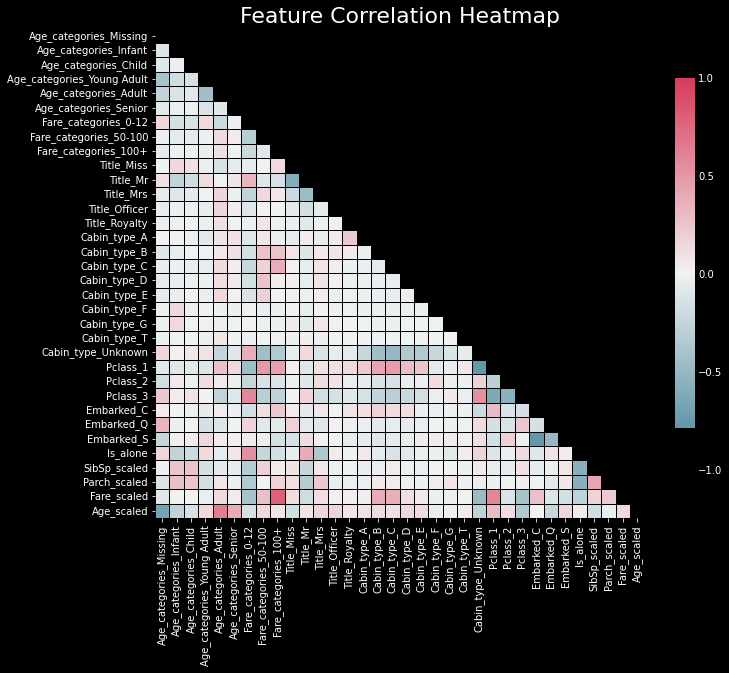

In [23]:
#cols to ignore to help reduce collinearity (more of an art than a science it seems)
cols_to_drop = ['Age_categories_Teenager', 'Fare_categories_12-50', 'Pclass',
                'Title_Master', 'Cabin_type', 'Sex_male', 'Sex_female',
                'SibSp', 'Parch', 'Fare', 'Age', 'Pclass', 'Sex', 'Embarked',
                'Ticket', 'Title']

columns = list(train.columns)
columns = [ x for x in columns if x not in cols_to_drop]

plot_correlation_heatmap(train[columns])

Above we can see how strongly our features are correlated to one another. The darker the color, the stronger the correlation.

In [24]:
#select best features again - this time with scaled data, with fewer columns to help reduce collinearity
best_columns_2 = select_features(train[columns])

Optimized columns: 7
 - Title_Miss
 - Title_Mr
 - Title_Mrs
 - Pclass_3
 - SibSp_scaled
 - Fare_scaled
 - Age_scaled


In [25]:
#grab the best performing model from our search
best_model_2 = select_model(train[columns], best_columns_2)

Using GridSearchCV...

Model: LogisticRegression
Best Score: 0.804681647940075
Best Params: {'C': 3.727593720314938, 'solver': 'newton-cg'}
-------------------------
Model: KNeighborsClassifier
Best Score: 0.8272159800249689
Best Params: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
---------------------------
Model: RandomForestClassifier
Best Score: 0.8373033707865168
Best Params: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 6}
-----------------------------
Model: SupportVectorMachine
Best Score: 0.7990761548064919
Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
---------------------------
Model: StochasticGradientDescent
Best Score: 0.8170411985018726
Best Params: {'sgd__alpha': 0.01, 'sgd__eta0': 1, 'sgd__l1_ratio': 0.2, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'hinge', 'sgd__penalty': 'l1'}
--------------------------------
Model: LinearPerceptron
Best Sc

In [26]:
#create score df
results_2 = score_comp(best_model_2, 'Grid + Scaling')

#compare scores
final_comp = pd.concat([results_1, results_2], axis=1)
final_comp

,Grid,Grid + Scaling
Model,,
LogisticRegression,0.792360,0.804682
KNeighborsClassifier,0.772260,0.827216
RandomForestClassifier,0.841848,0.837303
SupportVectorMachine,0.786729,0.799076
StochasticGradientDescent,0.801336,0.817041
LinearPerceptron,0.769875,0.755343


From our chart above, we can see that the scaling & removal of several columns has had a fairly positive impact on the predicted scores of our models. All of our models, except our **RandomForestClassifier** had improved scores! It is very important to note that these are just our predicted scores. If you are uploading your scores to Kaggle, you may expect slightly different results.

### Comparisons So Far...

At this point, I was curious to see the Kaggle Scores from each of our models. So I created a submission file for each model and submitted them to Kaggle. 

In [27]:
#save each models submission
for i in range(len(best_model_2)):
    model = best_model_2[i]['best_model']
    file  = best_model_2[i]['name'] + time.strftime("%Y%m%d_%H%M%S")
    end_results2 = save_submission_file(model, best_columns_2, file)

Created LogisticRegression20220225_104407.csv!
Created KNeighborsClassifier20220225_104407.csv!
Created RandomForestClassifier20220225_104407.csv!
Created SupportVectorMachine20220225_104407.csv!
Created StochasticGradientDescent20220225_104407.csv!
Created LinearPerceptron20220225_104407.csv!


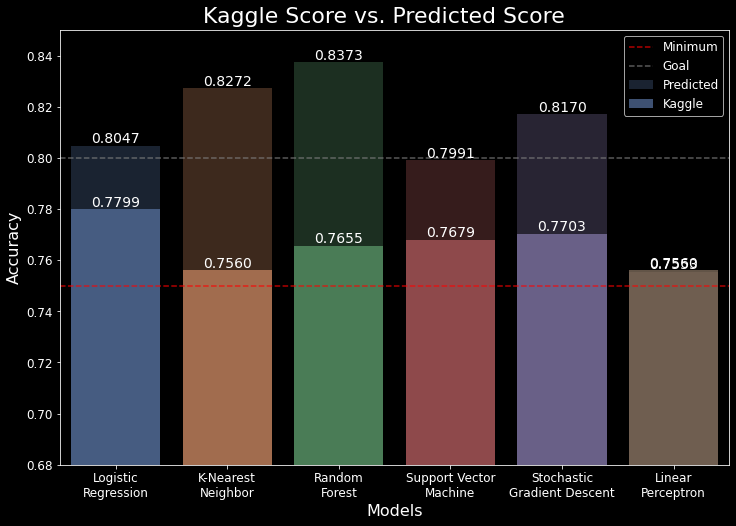

In [28]:
#need to input this manually - can it be automated?
kaggle = [0.77990, 0.75598, 0.76555, 0.76794, 0.77033, 0.75598]
# kaggle = [0.77033, 0.74162, 0.74162, 0.78708, 0.77511, 0.68181] - most recent
# kaggle = [0.78229, 0.75598, 0.75358, 0.76794, 0.77033, 0.75598] - oldest
plot_scores_vs_kaggle(best_model_2, kaggle)

### What Do These Results Mean?

From the above graph we can see that, surprisingly, our LogisticRegression model outperformed all other models. The darker colored bars in the plot represent our predicted values. You can easily see the difference between them and the brighter colored bars, which are the actual Kaggle Leaderboard scores given. So what can we gather from this? I think the biggest takeaway is that **our models are overfitting the data**. This means they can perform well with the training data, but perform poorly (or not as well) with the testing data. After we did some rescaling on a couple of the columns, as well as excluded some columns from the `select_model()` function, we can see that our predicted scores went up (for the most part). The red and grey dotten lines represent our minimum and goal values. These are a bit arbitrary, but my personal goal is to hit 80% accuracy. 

Seeing this plot helps us better understand how our models are fitting the data. It is worth experimenting further with all of our models to see if we can further reduce the overfitting that's occurring.

# Further Experimentation - RandomSearchCV vs. GridSearchCV

In our `select_model()` function, we use `GridSearchCV` to help with our hyperparameter tuning. Do we achieve any better scores with `RandomizedSearchCV` instead? Let's find out. We can achieve this simply by modifying our existing function to accept a "search flag" of sorts, that determines which search method to use.

## GridSearch vs. RandomizedSearch

GridSearch and RandomizedSearch are two very popular hyperparameter tuning approaches. Both have the same goal of finding the optimal hyperparameter settings for a given model, however there are definitely clear differences between the two:

* [**GridSearch**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html):
    * The "exhaustive" approach - it comprehensively checks every single possible combination of hyperparameter values
    * Very accurate
    * Can be slow due to the number of combinations it needs to test
* [**RandomizedSearch**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html):
    * The faster approach - it samples a randomly-selected subset of n combinations
    * Similar results compared to `GridSearch`
    * Due to the random aspect, *it's possible* for it to miss the optimal combination
    
Using the `RandomizedSearch` has potential to save us lots of computation time, while potentially sacrificing very little in terms of accuracy. I believe it is also critical to know that **it *is* a random search**, meaning that there is a tiny amount of "luck" involved when it comes to picking the optimal combination. It's very possible that it produces worse combinations than the `GridSearchCV` approach. It's a tradeoff between accuracy, time, and resources. Also, it's important to note that in order to employ `RandomizedSearch` you need to make sure your set of hyperparameters are configured correctly. If the parameter is a continous one, you need to make sure that it has a continuous distribution. 

>For continuous parameters ... it is important to specify a continuous distribution to take full advantage of the randomization. This way, increasing `n_iter` will always lead to a finer search. -[scikit-learn.org](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

Aside from this quirk, you need to be more knowledgeable overall of a model's hyperparameters in order to know which one is more important. It can be very confusing trying to wrap one's head around every single hyperparameter.



In [29]:
#use same columns as previous attempt - this time with RandomSearchCV
best_model_3 = select_model(train, best_columns_2, False)

Using RandomizedSearchCV...

Model: LogisticRegression
Best Score: 0.8046816479400748
Best Params: {'C': 1.3645253344035952, 'solver': 'newton-cg'}
-------------------------
Model: KNeighborsClassifier
Best Score: 0.8238451935081148
Best Params: {'weights': 'uniform', 'p': 1, 'n_neighbors': 3, 'algorithm': 'ball_tree'}
---------------------------
Model: RandomForestClassifier
Best Score: 0.8316978776529338
Best Params: {'n_estimators': 15, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy'}
-----------------------------
Model: SupportVectorMachine
Best Score: 0.8237952559300874
Best Params: {'C': 20.48124620065145, 'gamma': 0.20823699141630098, 'kernel': 'rbf'}
---------------------------
Model: StochasticGradientDescent
Best Score: 0.8159176029962547
Best Params: {'sgd__alpha': 0.0006535911662216769, 'sgd__eta0': 12.669389030827814, 'sgd__l1_ratio': 0.3258149135101016, 'sgd__learning_rate': 'adaptive', 'sgd__loss': 'hinge', '

# Final Comparisons

In [30]:
#create score df
results_3 = score_comp(best_model_3, 'Random + Scaling')

#compare scores
final_comp = pd.concat([results_1, results_2, results_3], axis=1)
final_comp

,Grid,Grid + Scaling,Random + Scaling
Model,,,
LogisticRegression,0.792360,0.804682,0.804682
KNeighborsClassifier,0.772260,0.827216,0.823845
RandomForestClassifier,0.841848,0.837303,0.831698
SupportVectorMachine,0.786729,0.799076,0.823795
StochasticGradientDescent,0.801336,0.817041,0.815918
LinearPerceptron,0.769875,0.755343,0.699164


In [31]:
#save each models submission
for i in range(len(best_model_3)):
    model = best_model_3[i]['best_model']
    file  = best_model_3[i]['name'] + time.strftime("%Y%m%d_%H%M%S")
    end_results3 = save_submission_file(model, best_columns_2, file)

Created LogisticRegression20220225_104410.csv!
Created KNeighborsClassifier20220225_104410.csv!
Created RandomForestClassifier20220225_104410.csv!
Created SupportVectorMachine20220225_104410.csv!
Created StochasticGradientDescent20220225_104410.csv!
Created LinearPerceptron20220225_104410.csv!


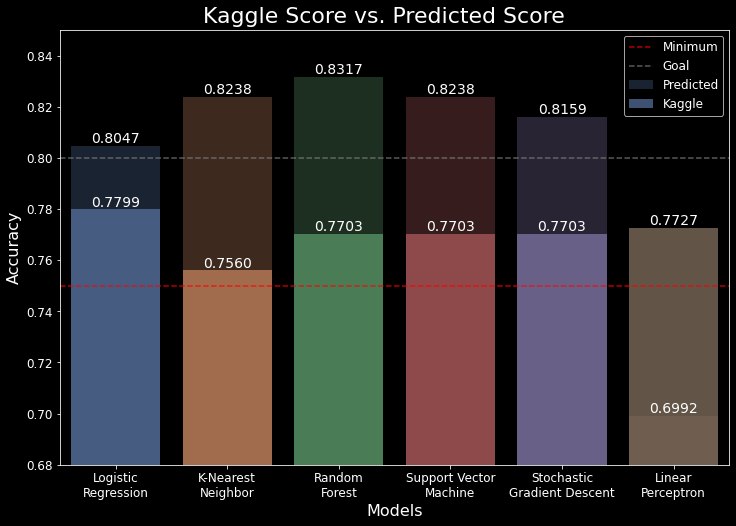

In [32]:
#need to input this manually - can it be automated?
kaggle_rs = [0.77990, 0.75598, 0.77033, 0.77033, 0.77033, 0.77272]
# kaggle = [0.77990, 0.75598, 0.76555, 0.76794, 0.77033, 0.75598] for quick comparison
plot_scores_vs_kaggle(best_model_3, kaggle_rs)

We can see that by using `RandomizedSearchCV` instead of `GridSearchCV`, our Kaggle scores actually improved for most of our models. Five out of six models scored **over 77%**! There also seems to have been less overfitting when `RandomizedSearchCV` was used. While I believe it is more than possible to further tweak and toy with all of the hyperparameter tuning, I feel like this is a good place to end the project. We have seen a lot of different models and the effects that the hyperparameter tuning has had on them. 

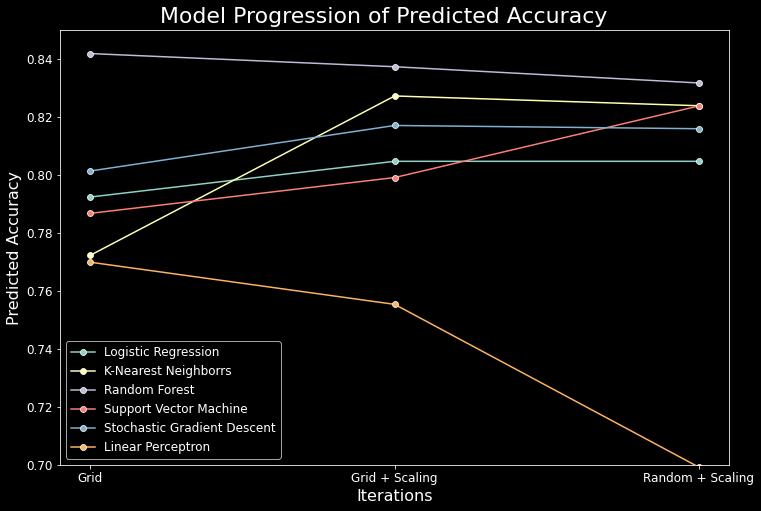

In [33]:
plot_model_progression(final_comp)

Above we can see our final plot that shows how our three iterations of our workflow affected the predicted accuracy of our models. It's clear that some models responded much better to our processing, feature engineering, and hyperparameter tuning than others.

# Closing Thoughts & Additional Steps

We can successfully say that we've created a relatively simple workflow to be used with Kaggle competitions, as well as other machine learning projects. One of the most challenging things was learning how to configure the hyperparameters for use with `RandomizedSearchCV`. There is an overwhelming amount of information on not only `RandomizedSearchCV`, but each individual model as well. I hope this project has served as a good basis for understanding how to create a good workflow, as well as how to pick, modify, and tune machine learning models. While this project is officially finished here, there are a few more additional steps one can take to further improve the results:

* Further tweak the hyperparameter settings for all models and for both `GridSearchCV` and `RandomizedSearchCV`
* Gain more domain knowledge for more feature engineering (combine cabin_types based on deck?)
* Gain more knowledge about individual models, strengths & weaknesses, unique quirks, etc..

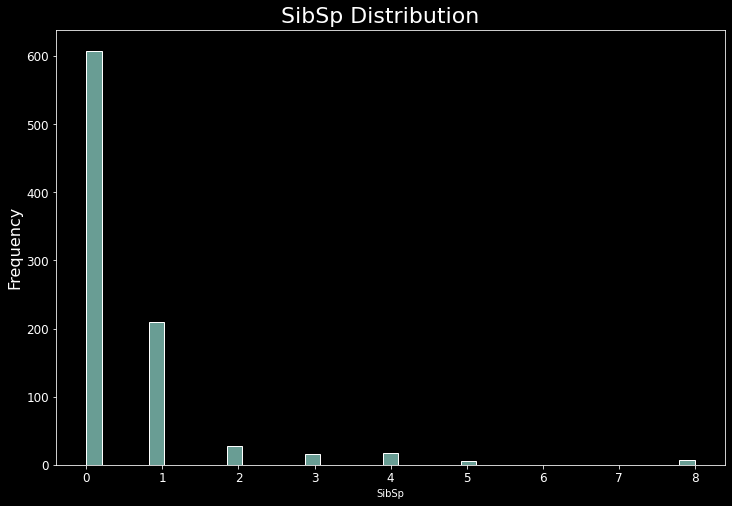

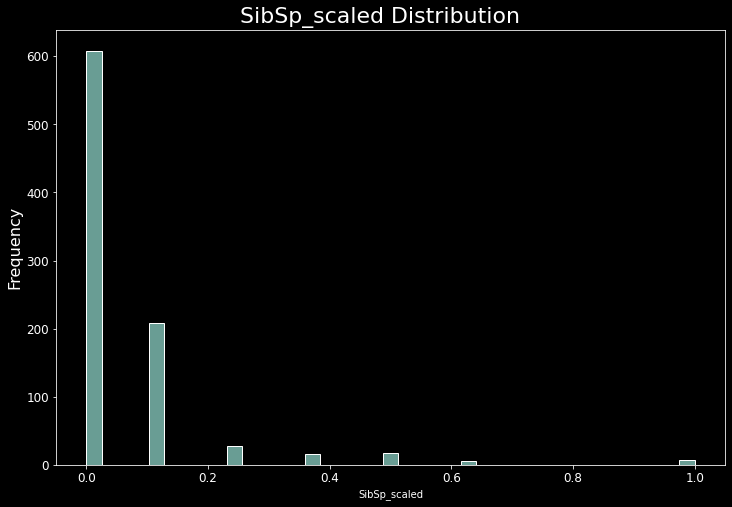

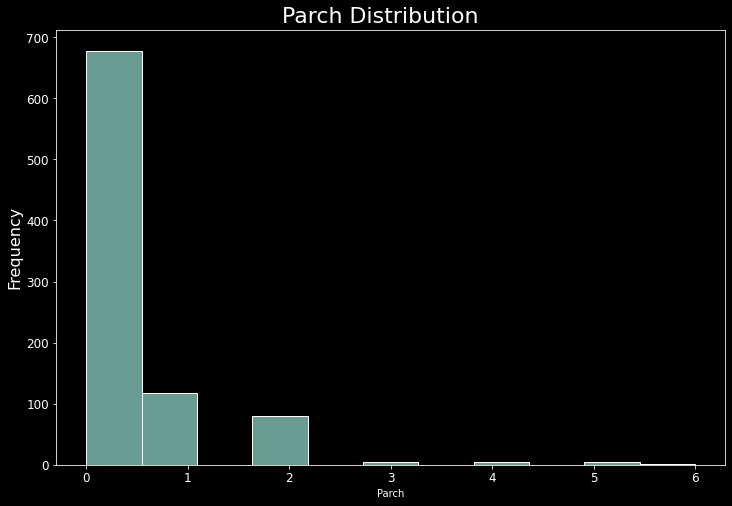

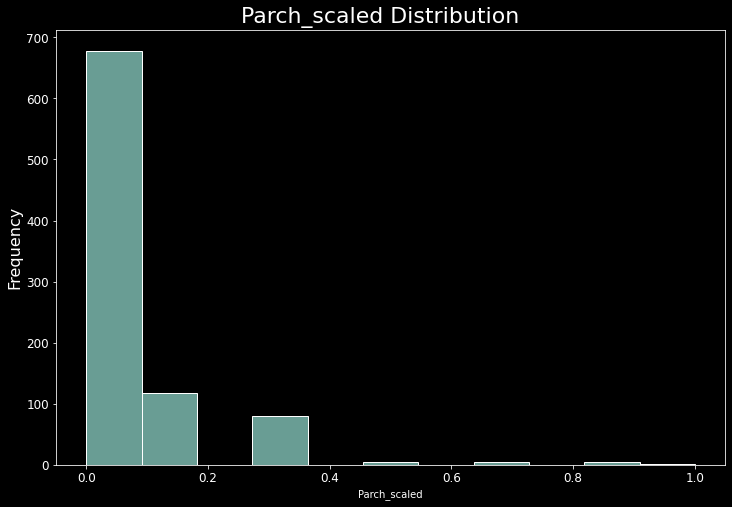

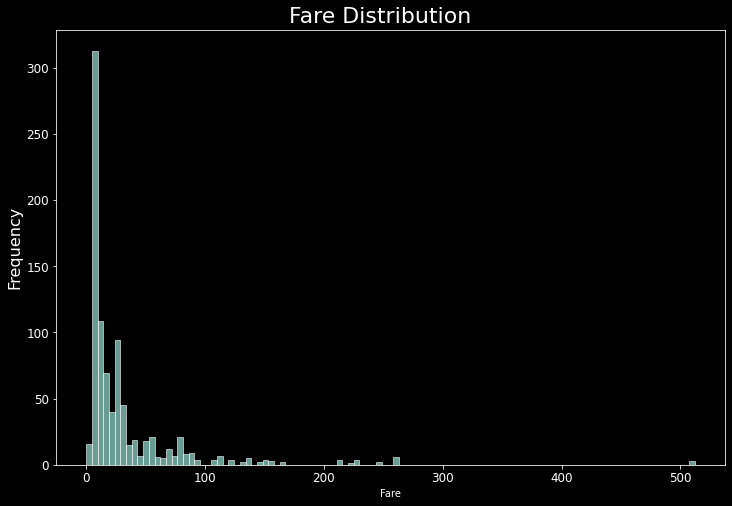

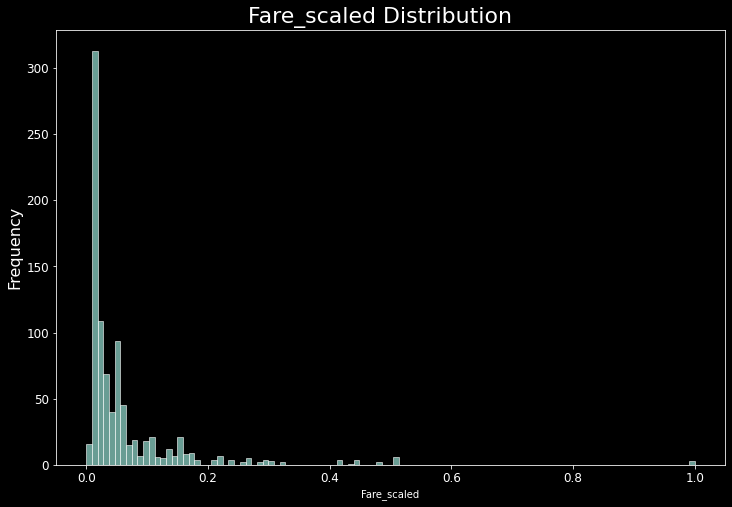

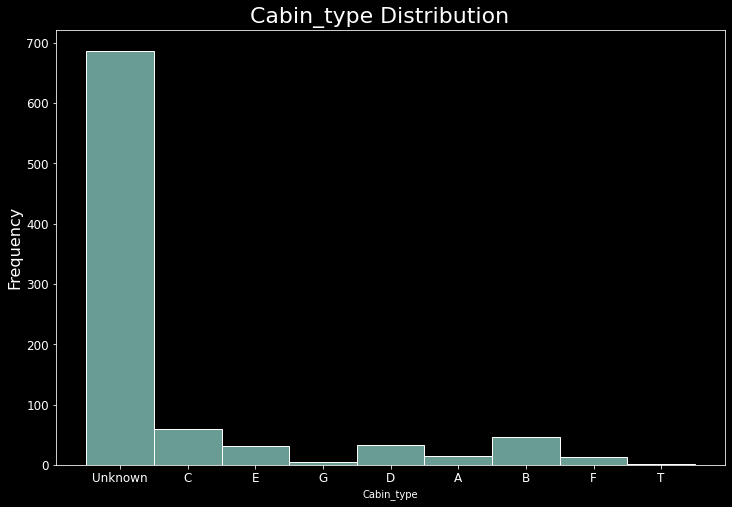

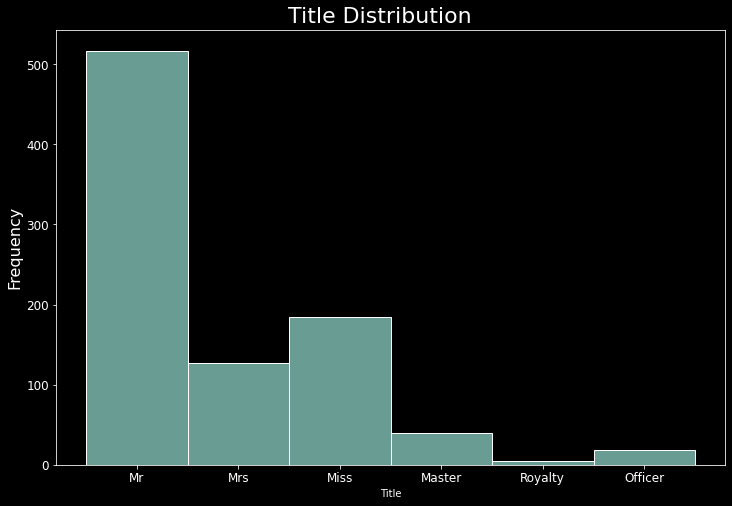

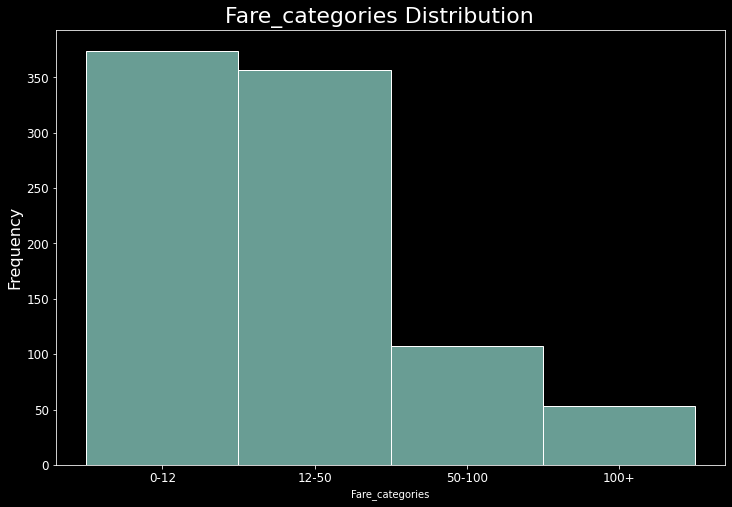

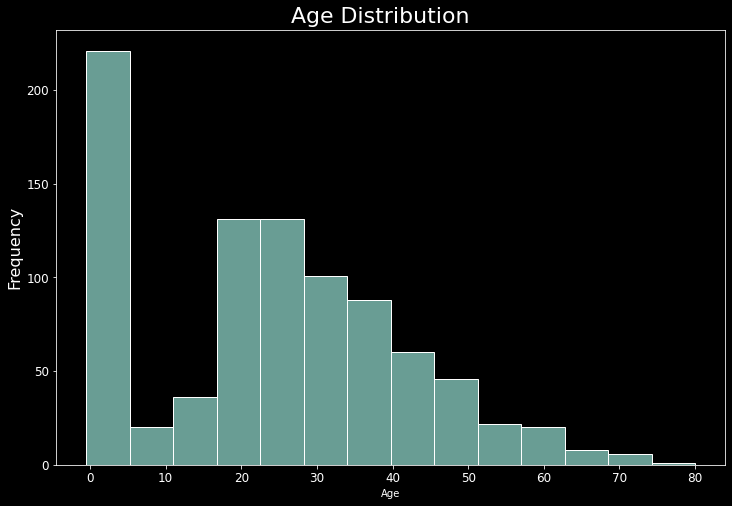

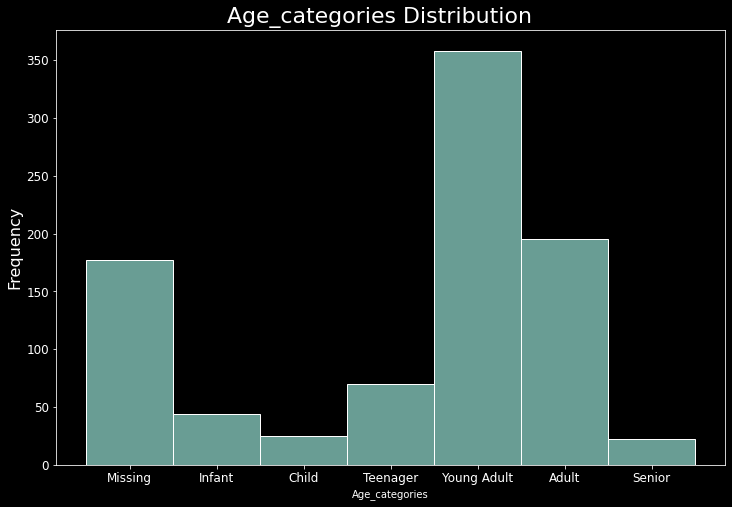

In [34]:
def plot_distr_info(column):
    #figure details
    fig, ax = plt.subplots(figsize = (12,8))
    fig.suptitle(f'{column} Distribution', fontsize=22, y=0.92)
    
    sns.histplot(data=train, x=column, palette='deep')

    #plot details    
    # ax.set_xlabel(f'{xlabel}', fontsize=16)
    ax.set_ylabel('Frequency', fontsize=16)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    # labels = ['Survived', 'Died']
    # ax.legend(labels, frameon=True, bbox_to_anchor=(1, 1), fontsize=14)
    plt.show()
    
cols = ['SibSp', 'SibSp_scaled', 'Parch', 'Parch_scaled', 'Fare', 'Fare_scaled', 'Cabin_type',
        'Title', 'Fare_categories', 'Age', 'Age_categories']
    
for col in train[cols]:
    plot_distr_info(col)